# Prognose Matchwinner internationaler Fußballspiele

Obwohl im Fußball immer wieder Überraschungssiege kleinerer Mannschaften vorkommen, lässt sich in der Regel jedoch der Gewinner eines Matches mit einer gewissen Wahscheinlichkeit voraussagen. 
Dies machen sich Wettanbieter zu nutzen, die eben diesen Wahrscheinlichkeiten einen gewissen Wert zuschreiben und den Kunden anbieten.
Der Fußballfan vergleicht  einfach die die jüngste Historie beider Teams, achtet auf die aktuelle Form in den letzten Monaten und entscheidet dann für sich, wer am ehesten dieses Spiel gewinnen wird.
Diese rein persönliche Entscheidung lässt sich aber auch anhand von Vergangenheitsdaten mit Hilfe von statistischen Modellen treffen. Dazu werden im Folgenden die Spiele von Nationalmannschaften der letzten drei Jahrzehnte und deren Weltranglistenplatz zu dem Zeitpunkt betrachtet. Auf Basis dieser Werte sollen so Wahrscheinlichkeiten über den Ausgang des Spiels ermittelt werden.

## Import der verwendeten Bibliotheken


In [609]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import poisson,skellam
import statsmodels.api as sm
import statsmodels.formula.api as smf
pd.options.mode.chained_assignment = None
import datetime

## Import der verwendeten Dateien und Datensätze in ein DataFrame.
Die Dateien _results_ und _ranking_ sind jeweils originale Datensätze von _kaggle.com_.  Die Datei _connection_ entstand durch einen manuellen Vergleich beider Datensätze und beinhaltet ausschließlich Daten aus beiden oben genannten Datensätzen. In der Datei results sind die Ergebnisse von offiziellen Spielen der Nationalmannschaften eingetragen. Im Zeitraum von Ende 1872 bis Mitte 2022 wurden in diesem Datensatz 43752 Spiele erfasst. Die Spiele reichen von offiziellen FIFA World Cup über FIFI Wild Cup bis hin zu regulären Freundschaftsspielen.

In [560]:
df_results = pd.read_csv("results.csv")
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


Der Datensatz _ranking_ enthält die Platzierungen der Nationalmannschaften zu jedem Update des offiziellen FIFA World Rankings der Männer. 

In [561]:
df_ranking = pd.read_csv("fifa_ranking.csv")
df_ranking.head()

,id,rank,country_full,country_abrv,total_points,previous_points,rank_change,confederation,rank_date
0,43818,82,Iraq,IRQ,15,0,0,AFC,1992-12-31
1,43873,107,Mozambique,MOZ,9,0,0,CAF,1992-12-31
2,43816,108,Indonesia,IDN,9,0,0,AFC,1992-12-31
3,1882218,109,Antigua and Barbuda,ATG,8,0,0,CONCACAF,1992-12-31
4,43820,110,Jordan,JOR,8,0,0,AFC,1992-12-31


Die Datei _connection_ verbindet die Bezeichnungen der aktuellen Nationalmannschaften in beiden Datensätzen.

In [575]:
df_connection = pd.read_csv("Connection.csv")
df_connection.head()

,ranking,results
0,Afghanistan,Afghanistan
1,Albania,Albania
2,Algeria,Algeria
3,American Samoa,American Samoa
4,Andorra,Andorra


Mit dem folgenden Code werden jedem Spiel die Weltranglistenpaltzierungen beider Mannschaften zugeordnet. Um die Einträge im Ranking durchsuchen zu können, müssen die verwendeten Länderbezeichnungen in beiden Datensätzen miteinander verbunden werden.

In [578]:
# Beschränkung der Ergebnisdaten auf den Zeitraum, in dem auch die Weltranglistenposition ermittelt werden kann
df_results = df_results.loc[(df_results_1["date"] > "1992-12-31") & (df_results_1["date"] < "2021-05-27")] 

home_team_rank = []

# Funktion zur Ermittlung der Weltranglistenposition einer Mannschaft an einem bestimmten Datum
def search_rank(country, date):
    try:
        x = df_ranking.loc[(df_ranking["country_full"] == country) & (df_ranking["rank_date"] <= date)].iloc[-1,1]
    except IndexError:
        x = 0
    return x

# Erstellen eines Dictionarys mit der in dem Ranking verwendeten Länderbezeichnung als Wert und
# der bei den Ergebnissen verwendeten Länderbezeichnung als Schlüssel
ranking_name = {}
for index, row in df_connection.iterrows():
    ranking_name[row[1]] = row[0]

# Erstellen eines Dictionarys zur Überprüfung der aktuell noch bestehenden Nationalmannschaften
home_teams = df_results["home_team"].tolist()
away_teams = df_results["away_team"].tolist()
teams = home_teams + away_teams
teams = list(set(teams))
existing_countries = df_connection["results"].tolist()
country_test = {}

for i in teams:
    if i in existing_countries:
        country_test[i] = True
    else:
        country_test[i] = False

# Löschen der Zeilen im Ergebnis-DataFrame mit Spiel bei Teilnahme einer nicht mehr bestehenden Nationalmannschaft
for i in country_test:
    if country_test[i] == False:
        df_results.drop(df_results[df_results["home_team"] == i].index, inplace = True)
        df_results.drop(df_results[df_results["away_team"] == i].index, inplace = True)

_Berechnungsdauer des folgenden Abschnitts auf meinem Gerät: ca. 6:30 min_

In [580]:
# Hinzufügen leerer Spalten für die Weltranglistenplatzierung beider Teams
df_results["home_team_rank"] = None          
df_results["away_team_rank"] = None

# Zuordnung der Weltranglistenplatzierung
for index, row in df_results.iterrows():
    home_team = row[df_results.columns.get_loc("home_team")]
    away_team = row[df_results.columns.get_loc("away_team")]
    date = row[df_results.columns.get_loc("date")]
    home_team_rank = search_rank(ranking_name[home_team], date)
    away_team_rank = search_rank(ranking_name[away_team], date)
    df_results.at[index, "home_team_rank"] = home_team_rank
    df_results.at[index, "away_team_rank"] = away_team_rank

Entfernen von Spielen aus dem Datensatz, bei denen eine der Mannschaften keine Weltranglistenplatzierung zugeordnet werden konnte. Es verbleiben knapp über 20.000 Spiele, auf Basis dessen nun die Mannschaftsstärke ermittelt werden kann.

In [587]:
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_rank,away_team_rank
17549,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,39,69
17550,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,55,97
17551,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,71,161
17552,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,97,69
17553,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,55,39


In [585]:
df_results.drop(df_results[df_results["home_team_rank"] == 0].index, inplace = True)
df_results.drop(df_results[df_results["away_team_rank"] == 0].index, inplace = True)

## Weltranglistenplatzierung der Deutschen Nationalmannschaft ab 2010 bis zur EM 2021

Die Analysen und Darstellungen lassen sich auf unterschiedliche Nationen anwenden. Beispielhaft werden in den folgenden Abschnitten die Spiele und Weltranglistenplatzierungen der deutschen Nationalmannschaft betrachtet.

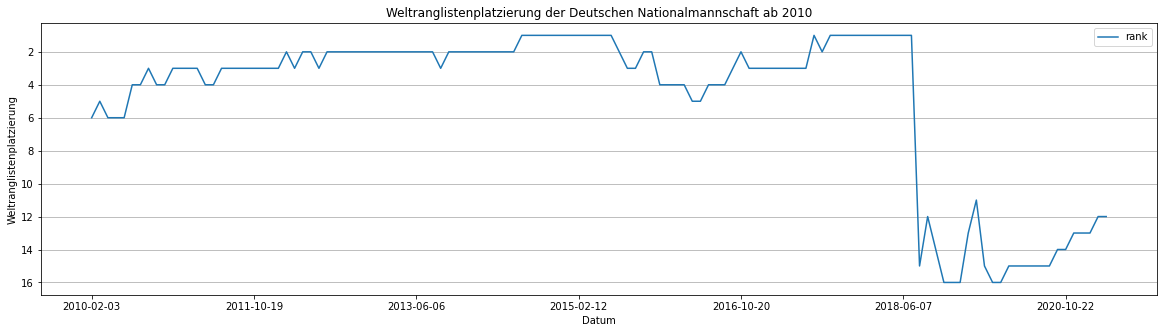

In [590]:
#Auswahl der Daten und Darstellung im Diagramm
selected_team = "Germany"
ranking_Germany = df_ranking.loc[(df_ranking["country_full"] == selected_team) &
                                 (df_ranking["rank_date"] >= "2010-01-01")]
ranking_Germany.plot( kind = "line", x = "rank_date", y = "rank")

# Anpassung der Darstellung
plt.gcf().set_size_inches(20, 5)
plt.gca().invert_yaxis()
plt.grid(axis="y")
plt.title("Weltranglistenplatzierung der Deutschen Nationalmannschaft ab 2010")
plt.ylabel("Weltranglistenplatzierung")
plt.xlabel("Datum")
plt.show()

## Anzahl der Siege gegen andere Nationalmannschaften

Um die Siege einer Mannschaft ermitteln zu können, muss zuerst der Ausgang eines Matches definiert werden. Die Mannschaft, welche mehr Tore schießt gewinnt, die andere verliert. Bei gleicher Anzahl an Toren wird von einem Unentschieden ausgegangen, mögliche Verlängerungen oder Elfmeterschießen werden nicht betrachtet. Auf Basis dessen wird für jedes Spiel der Sieger ermittelt.

In [592]:
conditions = [
    (df_results["home_score"] > df_results["away_score"]),
    (df_results["home_score"] == df_results["away_score"]),
    (df_results["home_score"] < df_results["away_score"])
    ]

values_home = ["W", "D", "L"]
values_away = ["L", "D", "W"]

df_results["result_home"] = np.select(conditions, values_home)
df_results["result_away"] = np.select(conditions, values_away)

values_winner = [df_results["home_team"], None, df_results["away_team"]]
values_loser = [df_results["away_team"], None, df_results["home_team"]]

df_results["winner"] = np.select(conditions, values_winner)
df_results["loser"] = np.select(conditions, values_loser)

Um die Statistik der deutschen Nationalmannschaft gegenüber anderen übersichtlich darzustellen, werden alle Spiele aus Sicht der deutschen Nationalmannschaft in eine neue Tabelle eingefügt.

In [593]:
# Auswahl der Spiele mit deutscher Beteiligung
matches_germany_2 = df_results.loc[(df_results["home_team"] == selected_team) | 
                                   (df_results["away_team"] == selected_team)]

# Erstellen einer Liste mit den Spielen der deutschen Mannschaft aus ihrer Sicht
matches_germany_list = []
for index, row in matches_germany_2.iterrows():
    country = row[df_results.columns.get_loc("country")]
    neutral = row[df_results.columns.get_loc("neutral")]
    date = row[df_results.columns.get_loc("date")]
    if row[df_results.columns.get_loc("home_team")] == selected_team:
        if neutral is False:
            character = "home"
        else:
            character = neutral
        opponent = row[df_results.columns.get_loc("away_team")]
        own_score = row[df_results.columns.get_loc("home_score")]
        opponents_score = row[df_results.columns.get_loc("away_score")]
        result = row[df_results.columns.get_loc("result_home")]
        own_ranking = row[df_results.columns.get_loc("home_team_rank")]
        opponents_ranking = row[df_results.columns.get_loc("away_team_rank")]
    else:
        if neutral is False:
            character = "away"
        else:
            character = neutral
        opponent = row[df_results.columns.get_loc("home_team")]
        own_score = row[df_results.columns.get_loc("away_score")]
        opponents_score = row[df_results.columns.get_loc("home_score")]
        result = row[df_results.columns.get_loc("result_away")]
        own_ranking = row[df_results.columns.get_loc("away_team_rank")]
        opponents_ranking = row[df_results.columns.get_loc("home_team_rank")]
    matches_germany_list.append([date, opponent, character, own_score, opponents_score, result
                                 , own_ranking, opponents_ranking, country, neutral])

# Umwandlung der Liste in ein DataFrame
matches_germany = pd.DataFrame(matches_germany_list,
                               columns=['date', 'opponent', 'character', 'own_score', 'opponents_score', 'result',
                                          'own_ranking', 'opponents_ranking', 'country', 'neutral'])
matches_germany.head()

,date,opponent,character,own_score,opponents_score,result,own_ranking,opponents_ranking,country,neutral
0,1993-03-24,Scotland,away,1,0,W,1,23,Scotland,False
1,1993-04-14,Ghana,home,6,1,W,1,39,Germany,False
2,1993-06-10,Brazil,True,3,3,D,1,3,United States,True
3,1993-06-13,United States,away,4,3,W,1,24,United States,False
4,1993-06-19,England,True,2,1,W,1,5,United States,True


Die Statistik gegenüber den Top-10-Nationen aus der aktuellen Weltrangliste, lassen sich übersichtlich in einem gestapelten Balkendiagramm darstellen. 

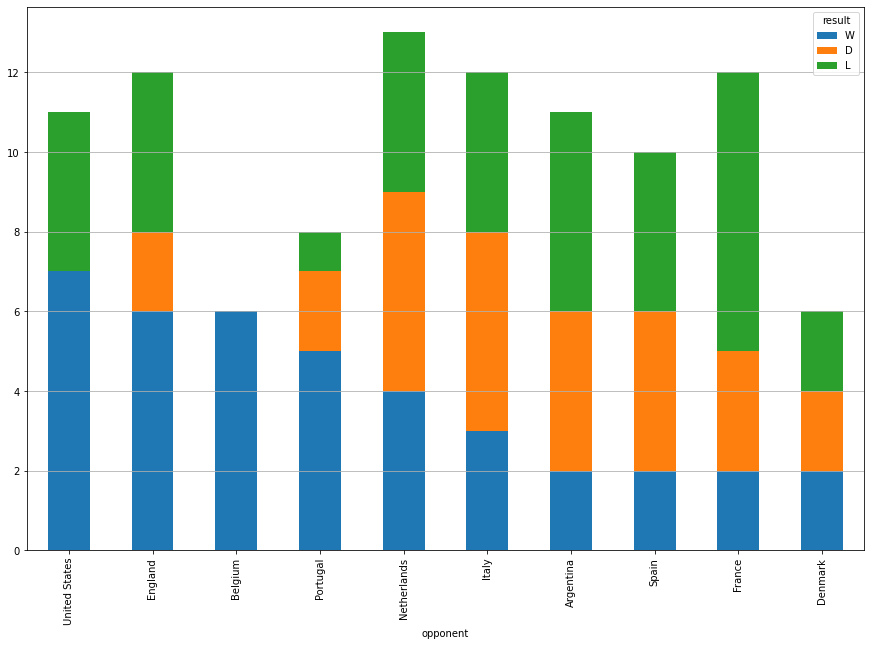

In [595]:
# Liste mit den Top 10 aus der aktuellen Weltrangliste
top_10 = ["France", "Portugal", "Italy", "England", "Netherlands",
                        "Spain", "United States", "Belgium", "Argentina", "Denmark"]

# Darstellung der Daten
pivot_matches_germany = pd.pivot_table(matches_germany, columns = "result", index = "opponent", aggfunc='count', values = "character")
pivot_matches_germany = pivot_matches_germany.replace(np.nan, 0)
pivot_matches_germany.sort_values(by = ["W", "D", "L"], inplace = True, ascending = False)
pivot_matches_germany = pivot_matches_germany[["W", "D", "L"]]
pivot_matches_germany.loc[top_10].sort_values(by = ["W", "D", "L"], ascending = False).plot.bar(stacked = True)
plt.gcf().set_size_inches(15, 10)
plt.grid(axis="y")
plt.show()

## Faktoren und deren Einfluss zueinander

Um die Einflussfaktoren ermitteln zu können, werden im folgenden die Daten ein weiteres Mal aufbereitet.

In [597]:
# Umwandlung des Datentyps der Weltranglistenplatzierung
df_results['home_team_rank'] = df_results['home_team_rank'].astype(str).astype(int)
df_results['away_team_rank'] = df_results['away_team_rank'].astype(str).astype(int)

# Erstellen neuer Spalten anhand bereits vorhandener Daten
conditions_points_home = [(df_results["result_home"] == "W"),
                          (df_results["result_home"] == "D"),
                          (df_results["result_home"] == "L")]
conditions_points_away = [(df_results["result_away"] == "W"),
                          (df_results["result_away"] == "D"),
                          (df_results["result_away"] == "L")]

values_points = [3, 1, 0]
values_outcome = [1, 0, -1]

df_results["points_home"] = np.select(conditions_points_home, values_points)
df_results["points_away"] = np.select(conditions_points_away, values_points)
df_results["Friendlies"] = np.where(df_results["tournament"] == "Friendly", True, False)
df_results["winner_home"] = np.where(df_results["points_home"] == 3, True, False)
df_results["goals_scored"] = df_results["home_score"] + df_results["away_score"]
df_results["diff"] = df_results["home_score"] - df_results["away_score"]
df_results["outcome_home"] = np.select(conditions_points_home, values_outcome)
df_results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_rank,...,result_away,winner,loser,points_home,points_away,Friendlies,winner_home,goals_scored,diff,outcome_home
17549,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,39,...,D,None,None,1,1,True,False,2,0,0
17550,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,55,...,D,None,None,1,1,True,False,2,0,0
17551,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,71,...,L,Kuwait,Lebanon,3,0,True,True,2,2,1
17552,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,97,...,L,Burkina Faso,Mali,3,0,True,True,1,1,1
17553,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,55,...,W,Ghana,Gabon,0,3,True,False,5,-1,-1


Anhand einer Korrelationsmatrix kann man den Einfluss unterschiedlicher Faktoren zueineander bestimmen.

,home_score,away_score,neutral,home_team_rank,away_team_rank,points_home,points_away,Friendlies,winner_home,goals_scored,diff,outcome_home
home_score,1.000000,-0.169315,-0.049446,-0.128776,0.297416,0.614386,-0.550823,-0.047455,0.616649,0.750936,0.828717,0.591361
away_score,-0.169315,1.000000,0.093338,0.215384,-0.157990,-0.584538,0.648478,-0.039044,-0.482232,0.523695,-0.691902,-0.624280
neutral,-0.049446,0.093338,1.000000,0.021649,0.032847,-0.080233,0.080704,-0.104981,-0.073164,0.019801,-0.089226,-0.081573
home_team_rank,-0.128776,0.215384,0.021649,1.000000,0.492171,-0.199162,0.211855,-0.099987,-0.171938,0.033006,-0.216646,-0.208197
away_team_rank,0.297416,-0.157990,0.032847,0.492171,1.000000,0.254836,-0.237287,-0.091368,0.248373,0.151221,0.307595,0.249654
points_home,0.614386,-0.584538,-0.080233,-0.199162,0.254836,1.000000,-0.945942,-0.002082,0.962208,0.139397,0.782020,0.987002
points_away,-0.550823,0.648478,0.080704,0.211855,-0.237287,-0.945942,1.000000,-0.017795,-0.821871,-0.041611,-0.771765,-0.985770
Friendlies,-0.047455,-0.039044,-0.104981,-0.099987,-0.091368,-0.002082,-0.017795,1.000000,-0.018597,-0.067181,-0.012592,0.007738
winner_home,0.616649,-0.482232,-0.073164,-0.171938,0.248373,0.962208,-0.821871,-0.018597,1.000000,0.209903,0.725582,0.905938
goals_scored,0.750936,0.523695,0.019801,0.033006,0.151221,0.139397,-0.041611,-0.067181,0.209903,1.000000,0.252723,0.092866


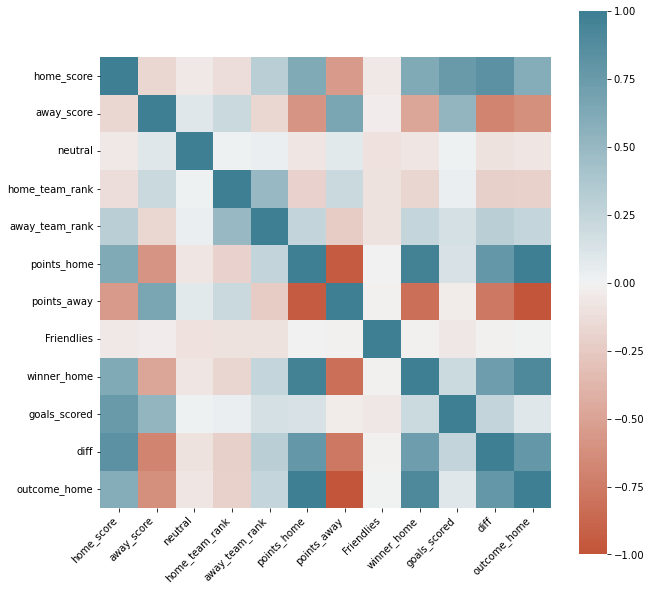

In [598]:
# Darstellung der numerischen Werte in einer Korrelationsmatrix und einer Heatmap
corrM = df_results.corr()
ax = sns.heatmap(
    corrM, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right')
corrM

Anhand der Korrelationsmatrix und der übersichtlichen farbigen Darstellung lassen sich einige Zusammenhänge erkennen. Neben den logischen fußballerischen Zusammenhängen, dass die geschossenen Tore einen signifikanten Einfluss zur Erhöhung der Punkteausbeute haben und in der Regel die Tor- und Punktausbeite des Gegner senkt, gibt es auch weniger offensichtliche Zusammenhänge.
So werden bei Turnieren im Schnitt mehr Tore geschossen als bei Freundschaftsspielen. Auch ist es wahrscheinlicher, dass bei einer hohen Anzahl an geschossenen Toren das Heimteam als Gewinner vom Platz geht. Letzteres lässt sich auch anhand der Korrelation zwischen den insgesamt geschossenen Toren eines Teams und den des Heimteams erkennen, wenn man bedenkt, dass die Tor- mit der Punktausbeute positiv korreliert.
Es bestätigt sich auch, dass der Favorit einer Partie nach der Weltranglistenplatzierung auch eher als Sieger aus der Partie hervorgehen wird.

Mit einer linearen Regression mit dem Spielausgang und der Tordifferenz aus dem Spiel lässt sich auch der Vorteil des Heimspiels beweisen. So liegt der y-Achsenabschnitt bei 0,11 und somit schon auf der Seite des Heimteams. Auch schießt die Heimmannschaft im Schnitt 0,44 Tore mehr pro Spiel.

In [604]:
X = df_results[["outcome_home"]]
y = df_results[["diff"]]
regressor = LinearRegression()
regressor.fit(X, y)
print("y-Achsenabschnitt [Tore]:", round(regressor.intercept_[0], 2))

average_home_goals = round(df_results["home_score"].mean(),2)
average_away_goals = round(df_results["away_score"].mean(),2)
print("Durchschnittlich geschossene Tore des Heimteams:", average_home_goals)
print("Durchschnittlich geschossene Tore des Auswärtsteams:", average_away_goals)

y-Achsenabschnitt [Tore]: 0.11
Durchschnittlich geschossene Tore des Heimteams: 1.61
Durchschnittlich geschossene Tore des Auswärtsteams: 1.07


## Modell zum Ausgang eines Spiels
Anhand des Spiels Deutschland vs. Brasilien bei der WM 2014, wird im folgenden einmal die Berechnungsmethode vorgestellt. Da die Vorhersage nur mit den zu dem Zeitpunkt verfügbaren Daten hätte geschehen können, werden die Daten nur bis zu Datum des Spiels betrachtet.

In [606]:
# Auswahl der Spiele
prediciton_data = df_results.loc[df_results["date"] < "2014-07-08"]
prediciton_data.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,home_team_rank,...,result_away,winner,loser,points_home,points_away,Friendlies,winner_home,goals_scored,diff,outcome_home
17549,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,39,...,D,None,None,1,1,True,False,2,0,0
17550,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,55,...,D,None,None,1,1,True,False,2,0,0
17551,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,71,...,L,Kuwait,Lebanon,3,0,True,True,2,2,1
17552,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,97,...,L,Burkina Faso,Mali,3,0,True,True,1,1,1
17553,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,55,...,W,Ghana,Gabon,0,3,True,False,5,-1,-1


Für die Wahscheinlichkeit des Eintretens eines Events in einem gewissen Zeitraum wird die Poissionsverteilung herangezogen. Damit lassen sich erste Vorhersagen über den Ausgang eines Spiels machen. So liegt die generelle Wahrscheinlichkeit für einen Heimsieg mit exakt drei Toren Vorsprung lediglich bei 7,2 %, die eines Unentschiedens bei 24,8 %.

In [618]:
print("Wahrscheinlichkeit für ein Unentscheiden:", round(skellam.pmf(0.0, average_home_goals, average_away_goals),3))
print("Wahrscheinlichkeit für einen Heimsieg mit drei Toren Vorsprung:", round(skellam.pmf(3.0, average_home_goals, average_away_goals),3))

Wahrscheinlichkeit für ein Unentscheiden: 0.248
Wahrscheinlichkeit für einen Heimsieg mit drei Toren Vorsprung: 0.072


Zur Vorhersage der genauen Ergebnisse werden Generalized Linear Models herangezogen. Es wird angenommen, dass die teilnehmenden Mannschaften und deren aktuelle Form anhand der Weltranglistenplatzierung Einfluss auf die erzielten Tore haben.

In [623]:
# Erstellen der statistischen Modelle
formula_home_goals = "home_score ~ home_team + away_team + home_team_rank + away_team_rank"
formula_away_goals = "away_score ~ home_team + away_team + home_team_rank + away_team_rank"
data = prediciton_data

model_home_goals = smf.glm(formula = formula_home_goals, data = data,
                        family=sm.families.Poisson()).fit()
model_away_goals = smf.glm(formula = formula_away_goals, data = data,
                        family=sm.families.Poisson()).fit()

Auf das oben genannte Halbfinalspiel zwischen Deutschland und Brasilien lassen sich damit nur die Erwartungswerte für die Anzahl der Tore beider Mannschaften ermitteln.

In [636]:
expected_home_goals = model_home_goals.predict(pd.DataFrame(data={"home_team": "Germany", "away_team": "Brazil",
                                       "home_team_rank": 2 , "away_team_rank": 3},index=[1]))
expected_away_goals = model_away_goals.predict(pd.DataFrame(data={"home_team": "Germany", "away_team": "Brazil",
                                       "home_team_rank": 2 , "away_team_rank": 3},index=[1]))

print("Erwartungswert: Tore der deutschen Nationalmannschaft:", round(expected_home_goals[1], 2))
print("Erwartungswert: Tore der brasilianischen Nationalmannschaft:", round(expected_away_goals[1], 2))

Erwartungswert: Tore der deutschen Nationalmannschaft: 1.34
Erwartungswert: Tore der brasilianischen Nationalmannschaft: 1.79


Um die Wahrscheinlichkeiten des Eintreffens genauer Ergebnisse zu berechnen, wird das Modell auf mehrere potenzielle Ergebnisse angewendet.

In [671]:
# Definieren der Simulationszyklusses
def match_simulation(home_team, away_team, home_rank, away_rank, max_goals = 10):
    X_home_goals = model_home_goals.predict(pd.DataFrame(data={"home_team": home_team, "away_team": away_team,
                                       "home_team_rank": home_rank , "away_team_rank": away_rank},index=[1])).values[0]
    X_away_goals = model_away_goals.predict(pd.DataFrame(data={"home_team": home_team, "away_team": away_team,
                                       "home_team_rank": home_rank , "away_team_rank": away_rank},index=[1])).values[0]
    result_prediction = [[poisson.pmf(i, team_avg) for i in range(0, max_goals+1)] for team_avg in [X_home_goals, X_away_goals]]
    return(np.outer(np.array(result_prediction[0]), np.array(result_prediction[1])))

# Anwendung auf das Beispiel
test_match = match_simulation("Brazil", "Germany", 3, 2)
results_summary = pd.DataFrame(test_match)
print("Wahrscheinlichkeit für einen 7:1 Sieg Deutschlands:", round(results_summary.at[1,7]*100,5), "%")
results_summary

Wahrscheinlichkeit für einen 7:1 Sieg Deutschlands: 0.00389 %


,0,1,2,3,4,5,6,7,8,9,10
0,0.050428,0.055947,0.031035,0.011477,3.183345e-03,7.063491e-04,1.306093e-04,2.070054e-05,2.870764e-06,3.538838e-07,3.926146e-08
1,0.094692,0.105055,0.058277,0.021552,5.977568e-03,1.326357e-03,2.452533e-04,3.887072e-05,5.390616e-06,6.645101e-07,7.372374e-08
2,0.088904,0.098635,0.054715,0.020234,5.612230e-03,1.245292e-03,2.302638e-04,3.649501e-05,5.061151e-06,6.238965e-07,6.921788e-08
3,0.055647,0.061738,0.034247,0.012665,3.512814e-03,7.794547e-04,1.441270e-04,2.284300e-05,3.167881e-06,3.905100e-07,4.332494e-08
4,0.026123,0.028982,0.016077,0.005946,1.649058e-03,3.659079e-04,6.765912e-05,1.072344e-05,1.487133e-06,1.833214e-07,2.033850e-08
5,0.009811,0.010884,0.006038,0.002233,6.193084e-04,1.374177e-04,2.540956e-05,4.027216e-06,5.584969e-07,6.884684e-08,7.638178e-09
6,0.003070,0.003406,0.001890,0.000699,1.938191e-04,4.300633e-05,7.952192e-06,1.260360e-06,1.747875e-07,2.154635e-08,2.390449e-09
7,0.000824,0.000914,0.000507,0.000187,5.199235e-05,1.153653e-05,2.133191e-06,3.380940e-07,4.688709e-08,5.779849e-09,6.412425e-10
8,0.000193,0.000214,0.000119,0.000044,1.220367e-05,2.707860e-06,5.007035e-07,7.935758e-08,1.100536e-08,1.356649e-09,1.505127e-10
9,0.000040,0.000045,0.000025,0.000009,2.546178e-06,5.649689e-07,1.044670e-07,1.655720e-08,2.296162e-09,2.830517e-10,3.140303e-11


In der Tabelle sind die Wahrscheinlichkeiten für den Ausgang eines Matches bei bis zu 10 Toren eines Teams dargestellt. Die Zeilen stehen für die Tore Brasiliens und die Spalten für die Tore Deutschlands. Beispielhaft wurde die Wahrscheinlichkeit des realen Ausgangs ausgelesen. Addiert man die Wert oberhalb der Hauptdiagonalen erhält man die Wahrscheinlichkeit für einen Sieg Brasiliens. Die Werte für ein Unentschieden liegen auf Hauptdiagonalen und zur Berechnung der Wahrscheinlichkeit eines Siegs der deutschen Nationalmannschaft werden die Werte unterhalb der Hauptdiafonalen addiert.

In [679]:
percentage_home = round(np.sum(np.tril(test_match, -1)) *100 , 1)
percentage_draw = round(np.sum(np.diag(test_match))* 100, 1)
percentage_away = round(np.sum(np.triu(test_match, 1)) * 100, 1)
            
print("Wahrscheinlichkeit für einen Sieg Brasiliens:", percentage_home, "%")
print("Wahrscheinlichkeit für ein Unentschieden:", percentage_draw, "%")
print("Wahrscheinlichkeit für einen Sieg Deutschlands:", percentage_away, "%")

Wahrscheinlichkeit für einen Sieg Brasiliens: 55.3 %
Wahrscheinlichkeit für ein Unentschieden: 22.5 %
Wahrscheinlichkeit für einen Sieg Deutschlands: 22.2 %
